# I) Import librairies

In [1]:
import world_trade_data as wits
import pandas as pd
import geopandas as gpd
import numpy as np
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from requests.exceptions import HTTPError
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn import mixture
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
import pickle
from math import pi

# II) Data processing

Let's leverage the WITS (World Integrated Trade Solution) API to access data spanning from 1988 to 2020. It is essential to highlight that the dataset for France is accessible solely from 1994 to 2020. Consequently, for our analysis, we opted to utilize data from 2006 to 2020 to ensure the most comprehensive dataset available, given that the majority of France's export partner data is accessible from this timeframe onwards.

The data provided by the WITS API is classified according to product codes. However, several product codes can designate a single product. Therefore, to avoid repetition, one must consider the type of group and deduce the product codes that are unique for a given group:

In [2]:
# create a list of unique product name
product_name = wits.get_products()[wits.get_products()["grouptype"]=='Sector'].reset_index()["productdescription"].to_list()
product_name.remove('All Products')

##  Load foundational data

In [3]:
period = [str(year) for year in range(2006, 2021)] # convert to string because int is not iterable

# create a dataframe list which contains the list of dataframe of each France partner
dataframes_list = []

# list of each partners
countries_list = list(wits.get_countries().index)

# remove group of countries
countries_group = wits.get_countries()[wits.get_countries()['isgroup']=="Yes"].index.to_list() #list of group of countries
for item in countries_group:
    countries_list.remove(item)

# remove territories for which data on exports to France are not available/appropriate (including France itslef), overseas territories, unspecified territory, world data
countries_to_drop = ["ASM","AIA","ATA","ABW","BLX","BMU","BES","BVT","BAT","IOT","VGB","BUN","CYM","CXR","CCK","CUW","CSK","ETF","FLK","ATF","FRE","GUF","PYF","DDR","GLP","GUM","HMD","VAT","MYT","ANT","NZE","NCL","NFK","MNP","999","PSE","OAS","PCE","PLW","PCN","REU","SXM","SPM","SGS","SVU","SPE","TKL","TCA","UMI","UNS","USP","WLF","YUG"]

for item in countries_to_drop:
    countries_list.remove(item)
    
global_list=[]
for ctr in countries_list : 
    dataframes =[] 
    for year in period:
        try :
            temp = wits.get_indicator('MPRT-TRD-VL', reporter='fra', year=year,partner = ctr)[["Value"]]
            temp = temp.reset_index()[["Partner","ProductCode","Year","Value"]]
            temp = temp[temp['ProductCode'].isin(product_name)] # to get a single product name
            temp.rename(columns={"Value":year},inplace=True)
            temp = temp[["Partner","ProductCode",year]]
            dataframes.append(temp)
        
        except HTTPError:
            # Handle the error by creating an empty DataFrame with NaN values (when a given country has no data in a given time)
            temp = pd.DataFrame({'Partner': ctr, 'ProductCode': product_name,year: np.nan*len(product_name)})
            dataframes.append(temp)

    for df in dataframes[1:]: # drop useless columns and only keep the 'Partner' on the first dataframe
        df.drop('Partner', axis=1,inplace=True)

    result = dataframes[0]# select the first element of the dataframes list
    for df in dataframes[1:]:# then merge all remain dataframes on it
        result = result.merge(df, on='ProductCode', how='outer')# get an only one dataframe for a country which export to France
        result["Partner"] = result["Partner"].fillna(method='ffill')
        result = result.replace(np.nan,0)

    global_list.append(result)
    print(ctr,"done")

AFG done
ALB done
DZA done
AND done
AGO done
ATG done
ARG done
ARM done
AUS done
AUT done
AZE done
BHS done
BHR done
BGD done
BRB done
BLR done
BEL done
BLZ done
BEN done
BTN done
BOL done
BIH done
BWA done
BRA done
BRN done
BGR done
BFA done
BDI done
KHM done
CMR done
CAN done
CPV done
CAF done
TCD done
CHL done
CHN done
COL done
COM done
ZAR done
COG done
COK done
CRI done
CIV done
HRV done
CUB done
CYP done
CZE done
DNK done
DJI done
DMA done
DOM done
TMP done
ECU done
EGY done
SLV done
GNQ done
ERI done
EST done
SWZ done
ETH done
FRO done
FJI done
FIN done
SDN done
FRA done
GAB done
GMB done
GEO done
DEU done
GHA done
GIB done
GRC done
GRL done
GRD done
GTM done
GIN done
GNB done
GUY done
HTI done
HND done
HKG done
HUN done
ISL done
IND done
IDN done
IRN done
IRQ done
IRL done
ISR done
ITA done
JAM done
JPN done
JOR done
KAZ done
KEN done
KIR done
PRK done
KOR done
KWT done
KGZ done
LAO done
LVA done
LBN done
LSO done
LBR done
LBY done
LTU done
LUX done
MAC done
MDG done
MWI done
M

Presented below is a sample excerpt from our dataframe:

In [5]:
global_list[0]

,Partner,ProductCode,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Afghanistan,Vegetable,182.055,474.894,381.634,999.328,750.220,1256.958,1235.633,3190.749,3441.251,2072.756,3287.200,2978.669755,3166.014486,2231.176031,330.822329
1,Afghanistan,Food Products,12.555,0.000,7.367,0.000,0.000,1.601,0.183,20.944,50.887,93.123,49.323,50.656539,41.861639,64.258507,1.456853
2,Afghanistan,Chemicals,12.556,2.746,1.473,9.716,11.928,17.398,7.409,25.081,0.149,52.636,104.142,29.272637,15.490177,114.562914,12.427850
3,Afghanistan,Hides and Skins,33.900,1261.351,244.599,190.150,148.453,7.912,36.114,9.093,3.125,72.453,34.833,8.643860,1.252352,7.864367,10.662245
4,Afghanistan,Textiles and Clothing,156.944,102.939,138.508,126.304,29.161,21.693,50.058,135.143,201.104,97.699,459.148,783.224211,473.670260,408.131989,104.763073
5,Afghanistan,Stone and Glass,35.156,12.353,57.466,12.492,15.906,2248.168,2042.798,2623.513,55.351,3601.767,6150.235,3519.558879,3526.411866,2084.801842,479.125188
6,Afghanistan,Metals,1.256,104.312,8.841,0.000,1.325,2.686,2.827,24.870,36.432,14.455,37.083,5.121075,1.407124,3.522394,1.154962
7,Afghanistan,Mach and Elec,303.842,454.306,959.242,1894.561,555.374,942.468,1248.284,1343.993,258.858,104.859,321.609,115.728165,821.409434,246.373916,99.420515
8,Afghanistan,Miscellaneous,352.809,17.843,44.204,45.803,23.858,145.780,189.016,432.434,202.759,154.754,72.915,176.107636,84.477053,66.611995,43.164710
9,Afghanistan,Animal,0.000,69.999,0.000,9.716,239.911,0.000,12.314,0.000,0.000,0.000,0.000,1.935782,5.529252,0.000000,0.000000


In [8]:
# # To optimize performance and avoid the need for frequent data retrieval from the WITS API, consider serializing the dataframe as a Python object for convenient storage and efficient retrieval.
# with open('D:/Research/Papers/Clustering World-France trade/Data/df_list.pkl', 'wb') as f:
#     pickle.dump(global_list, f)

In [2]:
# Load the Python object saved above
with open('D:/Research/Papers/Clustering World-France trade/Data/df_list.pkl', 'rb') as f:
    global_list = pickle.load(f)

## Deflate values

Deflation is necessary to adjust for the real values of exports to France:

In [3]:
# import the US price index from World Bank 
price_usa=pd.read_excel("D:\Research\Papers\Clustering World-France trade\Data\Price index.xlsx")
price_usa = price_usa[46:-1]
price_usa["Année"]= price_usa["Année"].astype(str)
price_usa = price_usa.T
price_usa.columns = price_usa.iloc[0,:]
price_usa.drop("Année",axis=0,inplace=True)

In [4]:
# deflate values
global_list_2 = []
for i in range(0,len (global_list)):
    temp = pd.concat([global_list[i], price_usa], axis=0, ignore_index=True)
    temp = temp.set_index(["Partner","ProductCode"])
    temp = (temp*100).div(temp.iloc[-1])
    temp.reset_index(inplace=True)
    temp.drop(temp.index[-1],inplace=True)
    global_list_2.append(temp)

## Compute median data

Let's compile a comprehensive dataframe spanning from 2006 to 2020 by computing the median data. This consolidated dataframe organizes countries as rows and products as columns, facilitating streamlined analysis. Median is choosen to easily deal with outliers.

In [5]:
# create a list of computed sum
df_list = []
for i in range (0,len (global_list_2)):
    df = pd.DataFrame(global_list_2[i].set_index("ProductCode"))
    df = pd.DataFrame(df.iloc[:,1:].median(axis=1))
    df.columns = [global_list_2[i]["Partner"][0]]
    df_list.append(df)
# join all dataframes to get the final dataframe
df_final = df_list[0]
for df in df_list[1:]:
    df_final = df_final.join(df, how='outer')
df_final = df_final.replace(np.nan,0)


df = df_final.T # transpose the dataframe to have the country as data points and the product category as features
df

ProductCode,Animal,Chemicals,Food Products,Footwear,Fuels,Hides and Skins,Mach and Elec,Metals,Minerals,Miscellaneous,Plastic or Rubber,Stone and Glass,Textiles and Clothing,Transportation,Vegetable,Wood
Afghanistan,0.000000,13.451320,13.580357,1.325000,0.000000e+00,31.647085,477.779335,3.004323,0.000000,73.357964,88.047621,1778.170624,128.375440,22.183550,1218.492134,46.018907
Albania,1501.521678,1402.911947,1817.716433,10016.544114,1.248082e+03,185.185761,3326.900638,1213.737999,854.231130,1526.650979,960.699658,315.226872,18006.792102,6887.134426,2048.725110,1129.986232
Algeria,889.220130,144257.279526,7123.168207,4.022237,3.972868e+06,667.071934,8859.321238,476.660894,7973.916102,1556.405721,250.500742,733.383005,221.956195,688.521094,19199.675212,574.768958
Andorra,14.671649,288.954000,85.665341,43.458224,0.000000e+00,56.908798,871.971975,680.863086,0.567354,656.626052,73.001460,219.469941,521.394327,4904.263000,4.336532,441.384000
Angola,0.000000,3.916705,1.358577,4.363259,1.477166e+06,25.923877,1176.540421,220.105614,27.756763,988.172869,5.432143,1.595531,7.894532,92.552576,0.428736,100.337968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESH,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Yemen,1381.274254,28.762055,0.057108,0.000000,0.000000e+00,0.000000,22.623832,0.897508,0.000000,50.248943,0.000000,0.000000,0.855009,71.093105,46.620837,0.000000
YDR,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Zambia,32.962155,2.716071,2444.549135,0.245680,0.000000e+00,29.360431,15.231630,968.314181,0.000000,101.856463,1.358577,3413.613258,0.758629,0.184672,535.492000,1.235982


## Compute the Revealed Comparative Advantage 

We will use the RCA to assess each country's specialization worldwide in terms of exports to France.

In [6]:
df_rca = df.copy()
exp_tot = df_rca.sum().sum()
df_rca["Total_product"] = df_rca.sum(axis=1)
df_rca.loc["Total_country"] = df_rca.sum(axis=0)
df_rca

ProductCode,Animal,Chemicals,Food Products,Footwear,Fuels,Hides and Skins,Mach and Elec,Metals,Minerals,Miscellaneous,Plastic or Rubber,Stone and Glass,Textiles and Clothing,Transportation,Vegetable,Wood,Total_product
Afghanistan,0.000000e+00,1.345132e+01,1.358036e+01,1.325000e+00,0.000000e+00,3.164709e+01,4.777793e+02,3.004323e+00,0.000000e+00,7.335796e+01,8.804762e+01,1.778171e+03,1.283754e+02,2.218355e+01,1.218492e+03,4.601891e+01,3.895434e+03
Albania,1.501522e+03,1.402912e+03,1.817716e+03,1.001654e+04,1.248082e+03,1.851858e+02,3.326901e+03,1.213738e+03,8.542311e+02,1.526651e+03,9.606997e+02,3.152269e+02,1.800679e+04,6.887134e+03,2.048725e+03,1.129986e+03,5.244205e+04
Algeria,8.892201e+02,1.442573e+05,7.123168e+03,4.022237e+00,3.972868e+06,6.670719e+02,8.859321e+03,4.766609e+02,7.973916e+03,1.556406e+03,2.505007e+02,7.333830e+02,2.219562e+02,6.885211e+02,1.919968e+04,5.747690e+02,4.166344e+06
Andorra,1.467165e+01,2.889540e+02,8.566534e+01,4.345822e+01,0.000000e+00,5.690880e+01,8.719720e+02,6.808631e+02,5.673541e-01,6.566261e+02,7.300146e+01,2.194699e+02,5.213943e+02,4.904263e+03,4.336532e+00,4.413840e+02,8.863536e+03
Angola,0.000000e+00,3.916705e+00,1.358577e+00,4.363259e+00,1.477166e+06,2.592388e+01,1.176540e+03,2.201056e+02,2.775676e+01,9.881729e+02,5.432143e+00,1.595531e+00,7.894532e+00,9.255258e+01,4.287365e-01,1.003380e+02,1.479823e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yemen,1.381274e+03,2.876205e+01,5.710763e-02,0.000000e+00,0.000000e+00,0.000000e+00,2.262383e+01,8.975083e-01,0.000000e+00,5.024894e+01,0.000000e+00,0.000000e+00,8.550087e-01,7.109311e+01,4.662084e+01,0.000000e+00,1.602433e+03
YDR,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Zambia,3.296215e+01,2.716071e+00,2.444549e+03,2.456804e-01,0.000000e+00,2.936043e+01,1.523163e+01,9.683142e+02,0.000000e+00,1.018565e+02,1.358577e+00,3.413613e+03,7.586288e-01,1.846722e-01,5.354920e+02,1.235982e+00,7.547879e+03
Zimbabwe,7.132019e+01,4.157858e+00,3.724142e+03,4.353135e+00,0.000000e+00,1.708050e+04,2.714046e+01,3.729374e+02,2.262534e+02,1.954952e+02,1.592658e+01,4.400590e+02,7.461199e+00,5.334975e-01,2.342286e+03,4.232291e+00,2.451679e+04


In [7]:
warnings.filterwarnings('ignore')

for i in list(df_rca.index):
    if i != "Total_country" :
        for j in list(df_rca.columns):
            if j != "Total_product":
                df_rca.loc[i,j] = (df_rca.loc[i,j]/df_rca.loc[i,"Total_product"])/(df_rca.loc["Total_country",j].sum()/exp_tot)

# drop the total columns
df_rca = df_rca.iloc[:-1,:-1]

# delete rows containing only NaN values
df_rca = df_rca.dropna(how='all')

## Final data preparations 

Let's verify if there are any remaining missing data:

In [8]:
col_nan = df_rca.columns[df_rca.isna().any()].tolist()
print("Columns with NaN :", col_nan)

rows_nan = df_rca.index[df_rca.isna().any(axis=1)].tolist()
print("Rows with NaN :", rows_nan)

Columns with NaN : []
Rows with NaN : []


We should remove the 'Miscellaneous' column as it is unnecessary and may contain various types of products:

In [9]:
df_rca.drop("Miscellaneous",axis=1,inplace=True)

In [10]:
df_rca.describe()

ProductCode,Animal,Chemicals,Food Products,Footwear,Fuels,Hides and Skins,Mach and Elec,Metals,Minerals,Plastic or Rubber,Stone and Glass,Textiles and Clothing,Transportation,Vegetable,Wood
count,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000
mean,3.242744,0.672062,2.067352,0.852137,0.918650,1.327124,0.655547,0.600243,5.306268,0.424551,0.883240,1.765406,0.401218,4.716617,1.107036
std,7.718829,1.460376,4.086130,2.652107,2.085817,7.432886,1.022765,1.267708,21.857363,0.724513,2.809027,3.753080,1.054567,7.857266,3.136760
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000465,0.001501,0.018685,0.000214,0.000000,0.000044,0.020812,0.004620,0.000000,0.002023,0.001921,0.012431,0.000897,0.068314,0.007627
50%,0.173129,0.131340,0.450177,0.017319,0.000019,0.032186,0.149187,0.109366,0.003876,0.061030,0.055153,0.228983,0.020756,1.121431,0.160794
75%,1.728421,0.630592,1.850615,0.270562,0.313954,0.328679,0.883371,0.658511,0.340865,0.514944,0.469289,1.448385,0.220990,5.227312,0.753424
max,41.099457,8.612565,23.124281,21.324370,7.607218,95.235395,4.838565,8.112680,145.170282,4.591060,22.203246,19.959058,7.107563,32.533208,28.239679


In [11]:
# The input of our model
df_rca

ProductCode,Animal,Chemicals,Food Products,Footwear,Fuels,Hides and Skins,Mach and Elec,Metals,Minerals,Plastic or Rubber,Stone and Glass,Textiles and Clothing,Transportation,Vegetable,Wood
Afghanistan,0.000000,0.030178,0.082636,0.028013,0.000000,1.110553,0.593455,0.010891,0.000000,0.443852,22.203246,0.688583,0.040947,10.229884,0.382780
Albania,1.180225,0.233795,0.821599,15.730189,0.181111,0.482714,0.306956,0.326824,2.901090,0.359736,0.292376,7.174420,0.944295,1.277638,0.698172
Algeria,0.008798,0.302599,0.040526,0.000080,7.256565,0.021887,0.010289,0.001616,0.340865,0.001181,0.008562,0.001113,0.001188,0.150710,0.004470
Andorra,0.068231,0.284909,0.229093,0.403795,0.000000,0.877676,0.476006,1.084728,0.011400,0.161734,1.204389,1.229106,3.978465,0.016001,1.613536
Angola,0.000000,0.000023,0.000022,0.000243,7.596295,0.002395,0.003847,0.002100,0.003341,0.000072,0.000052,0.000111,0.000450,0.000009,0.002197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,11.821360,0.267237,0.973116,0.002676,2.735093,0.012380,0.011335,1.032169,33.846508,0.010653,0.011187,0.025812,0.022151,0.159156,0.010770
Vietnam,1.251617,0.024748,0.415180,15.027474,0.000036,4.445571,2.089172,0.160077,0.042626,0.508330,1.043908,2.561865,0.032639,1.466891,0.265373
Yemen,35.531449,0.156864,0.000845,0.000000,0.000000,0.000000,0.068313,0.007909,0.000000,0.000000,0.000000,0.011149,0.319004,0.951490,0.000000
Zambia,0.180013,0.003145,7.676923,0.002681,0.000000,0.531740,0.009764,1.811589,0.000000,0.003535,21.998255,0.002100,0.000176,2.320234,0.005306


# III) Modelling

Let's apply the N2D Deep Clustering to address our use case. 

N2D involves two main steps: (1) dimension reduction utilizing autoencoder and UMAP, and (2) clustering using Gaussian Mixture Model (GMM).

## Determine the number of clusters

We utilize both the Silhouette index and the Davis-Bouldin index to ascertain the optimal number of clusters. 

To determine the best number of clusters, we conduct our experiment 20 times and subsequently select the most optimal outcome.

In [17]:
warnings.filterwarnings("ignore")

def autoencoder(dims, act='relu'):
    n_stacks = len(dims) - 1
    x = Input(shape=(dims[0],), name='input')
    h = x
    for i in range(n_stacks - 1):
        h = Dense(dims[i + 1], activation=act, name='encoder_%d' % i)(h)
    h = Dense(dims[-1], name='encoder_%d' % (n_stacks - 1))(h)
    for i in range(n_stacks - 1, 0, -1):
        h = Dense(dims[i], activation=act, name='decoder_%d' % i)(h)
    h = Dense(dims[0], name='decoder_0')(h)

    return Model(inputs=x, outputs=h)    

# Initialize dataframes
df_silhouette = pd.DataFrame(columns=[f"exp_{i}" for i in range(1, 21)], index=range(2, 11))
df_db_score = pd.DataFrame(columns=[f"exp_{i}" for i in range(1, 21)], index=range(2, 11))

# Repeat the experiment 20 times
for exp in range(1, 21):
    results = []  # List to store the results
    for k in range(2, 11):
        shape = [df_rca.shape[-1], 100, 100, 200, k]
        autoencoder_model = autoencoder(shape)
        hidden = autoencoder_model.get_layer(name='encoder_%d' % (len(shape) - 2)).output
        encoder = Model(inputs=autoencoder_model.input, outputs=hidden)

        autoencoder_model.compile(loss='mse', optimizer="adam")
        autoencoder_model.fit(
            df_rca.values,
            df_rca.values,
            batch_size=256,
            epochs=1000,
            verbose=0)

        hl = encoder.predict(df_rca)

        # UMAP
        hle = umap.UMAP(
            random_state=42,
            metric="euclidean",
            n_components=2,
            n_neighbors=10,
            min_dist=0.00).fit_transform(hl)

        # Clustering with GMM
        gmm = mixture.GaussianMixture(
            covariance_type='full',
            n_components=k,
            random_state=42)
        gmm.fit(hle)

        labels = gmm.predict(hle)

        # Calculation of the silhouette score
        silhouette = silhouette_score(hle, labels)

        # Calculation of the Davies-Bouldin index
        db_score = davies_bouldin_score(hle, labels)

        # Sotre results in the list created earlier
        results.append({"k": k, "silhouette_score": silhouette, "db_score": db_score})

        # Store the results in the previously created list
        df_silhouette.loc[k, f"exp_{exp}"] = silhouette
        df_db_score.loc[k, f"exp_{exp}"] = db_score

    print(f"Experience {exp} finished")

# Add average in our dataframes columns
df_silhouette["Average"] = df_silhouette.mean(axis=1)
df_db_score["Average"] = df_db_score.mean(axis=1)

plt.style.use('ggplot')

# Plotting the metrics on separate figures
plt.figure(figsize=(10, 6))
plt.plot(df_silhouette.index,df_silhouette["Average"], label='Silhouette Score', marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(df_db_score.index, df_db_score["Average"], label='Davies-Bouldin score', marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('db_score')
plt.title('db_score vs Number of Clusters')
plt.legend()
plt.show()


7/7 [==============================] - 0s 1ms/step


Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x0000027457072D40>
Traceback (most recent call last):
  File "c:\Users\fitah\anaconda3\Lib\site-packages\llvmlite\binding\executionengine.py", line 171, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):

KeyboardInterrupt: 


7/7 [==============================] - 0s 785us/step


Let's create visualizations to depict the stability of each cluster score across our 20 experiments.

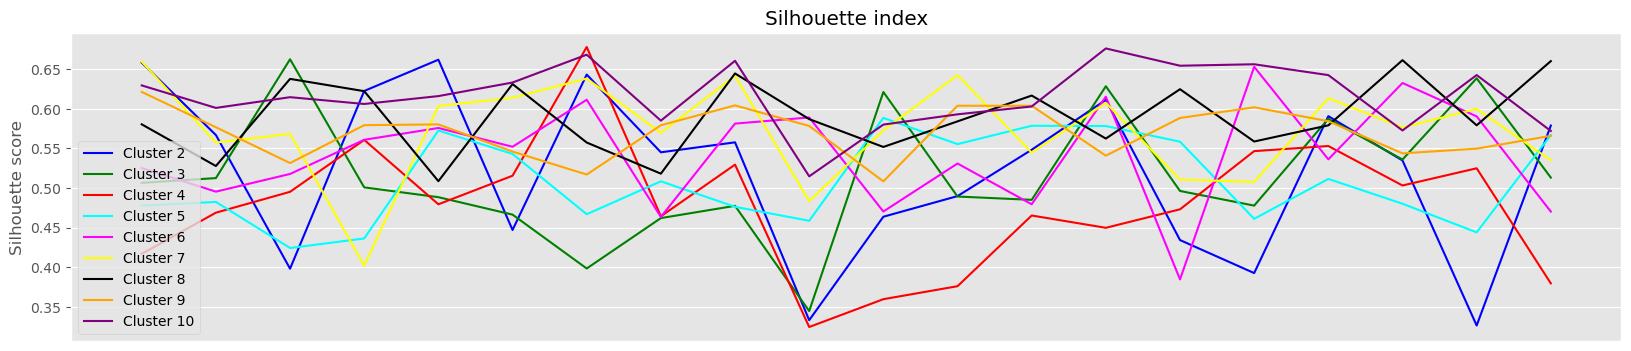

In [73]:
df_sil = df_silhouette.iloc[:,:-1]

plt.style.use('ggplot')

# Define the size
plt.figure(figsize=(20, 4)) 

# Define curves colors
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple', 'brown']

# Plot curves
for index, (color, row) in enumerate(zip(colors, df_sil.iterrows())):
    plt.plot(row[1].values, label=f'Cluster {row[0]}', color=color)

plt.ylabel('Silhouette score')
plt.title('Silhouette index')
plt.legend()
plt.xticks([])
plt.show()

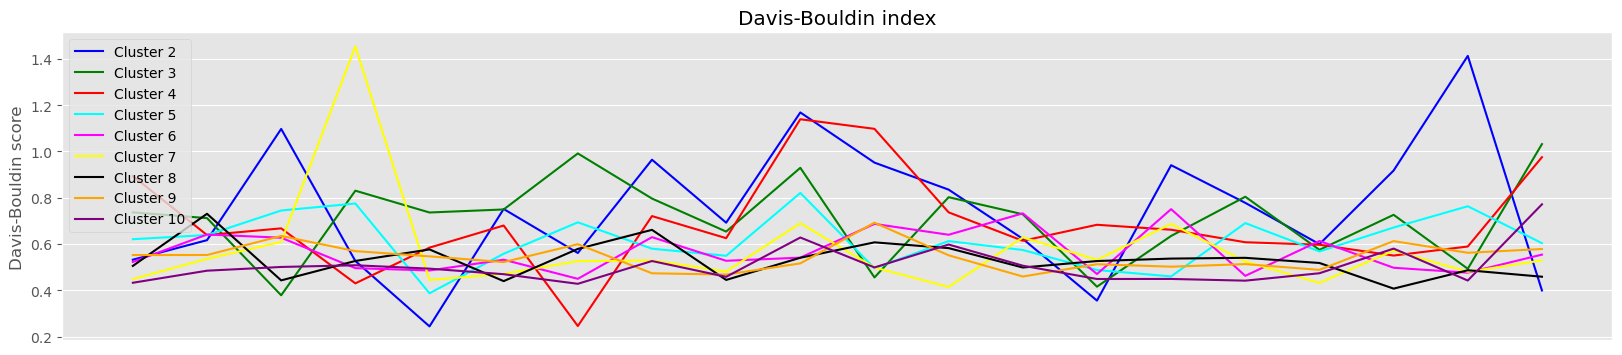

In [74]:
df_db = df_db_score.iloc[:,:-1]

plt.style.use('ggplot')

# Define the size
plt.figure(figsize=(20, 4)) 

# Define curves colors
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple', 'brown']

# Plot curves
for index, (color, row) in enumerate(zip(colors, df_db.iterrows())):
    plt.plot(row[1].values, label=f'Cluster {row[0]}', color=color)

plt.ylabel('Davis-Bouldin score')
plt.title('Davis-Bouldin index')
plt.legend()
plt.xticks([])
plt.show()

After k=10, we found that k=8 has the highest Silhouette score and the lowest Davies-Bouldin score. Moreover, cluster 8 appears to be a more suitable option than cluster 10 for grouping trade international partners based on export data, exhibiting greater stability across our experiments, particularly concerning the Davies-Bouldin score. Hence, we will select k = 8.

## Optimize hyperparameters

In [14]:
warnings.filterwarnings("ignore")

# Defining Hyperparameter Ranges
batch_sizes = [16, 24, 32, 64]
learning_rates = [0.0001, 0.001, 0.01]
epochs = [20, 50, 75, 100]
nodes_per_layer = np.arange(10, 1001)
alpha_beta = [(0.9, np.random.uniform(0.5, 1.0)) for _ in range(3)]


# Performing a Random Search
best_silhouette_score = -1
best_db_score = np.inf
best_model = None

for _ in range(100):
    # Randomly Selecting Hyperparameters
    batch_size = np.random.choice(batch_sizes)
    learning_rate = np.random.choice(learning_rates)
    epoch = np.random.choice(epochs)
    nodes = np.random.choice(nodes_per_layer, size=3)
    alpha = np.random.uniform(0.9, 1)
    beta = np.random.uniform(0.5, 1.0)

    # Build the autoencoder
    shape = [df_rca.shape[-1], *nodes, 8]
    autoencoder_model = autoencoder(shape)
    hidden = autoencoder_model.get_layer(name='encoder_%d' % (len(shape) - 2)).output
    encoder = Model(inputs=autoencoder_model.input, outputs=hidden)

    # Compile and train the autoencoder
    autoencoder_model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))
    autoencoder_model.fit(df_rca.values, df_rca.values, batch_size=batch_size, epochs=epoch, verbose=0)

    # Predict with the encoder
    hl = encoder.predict(df_rca)

    # UMAP
    hle = umap.UMAP(random_state=42, metric="euclidean", n_components=2, n_neighbors=10, min_dist=0.00, a=alpha, b=beta).fit_transform(hl)

    # Clustering with GMM
    gmm = mixture.GaussianMixture(covariance_type='full', n_components=8, random_state=42)
    gmm.fit(hle)
    labels = gmm.predict(hle)

    # Compute Silhouette and Davies-Bouldin score
    silhouette_avg = silhouette_score(hle, labels)
    db_score = davies_bouldin_score(hle, labels)

    # Updating the Best Model if Necessary
    if silhouette_avg > best_silhouette_score and db_score < best_db_score:
        best_silhouette_score = silhouette_avg
        best_db_score = db_score
        best_model = autoencoder_model
        best_labels = labels

7/7 [==============================] - 0s 4ms/step


In [15]:
# Put in dataframe the scores
data_scores = {
    'Best Silhouette_score': [best_silhouette_score],
    'Best DB score': [best_db_score]
}

df_scores = pd.DataFrame(data_scores)
df_scores

,Best Silhouette_score,Best DB score
0,0.786056,0.251772


In [33]:
df_class = df_rca.copy()
df_class["class"]  = best_labels # add to our initial dataframe the class found by the N2D
df_class

ProductCode,Animal,Chemicals,Food Products,Footwear,Fuels,Hides and Skins,Mach and Elec,Metals,Minerals,Plastic or Rubber,Stone and Glass,Textiles and Clothing,Transportation,Vegetable,Wood,class
Afghanistan,0.000000,0.030178,0.082636,0.028013,0.000000,1.110553,0.593455,0.010891,0.000000,0.443852,22.203246,0.688583,0.040947,10.229884,0.382780,3
Albania,1.180225,0.233795,0.821599,15.730189,0.181111,0.482714,0.306956,0.326824,2.901090,0.359736,0.292376,7.174420,0.944295,1.277638,0.698172,3
Algeria,0.008798,0.302599,0.040526,0.000080,7.256565,0.021887,0.010289,0.001616,0.340865,0.001181,0.008562,0.001113,0.001188,0.150710,0.004470,4
Andorra,0.068231,0.284909,0.229093,0.403795,0.000000,0.877676,0.476006,1.084728,0.011400,0.161734,1.204389,1.229106,3.978465,0.016001,1.613536,1
Angola,0.000000,0.000023,0.000022,0.000243,7.596295,0.002395,0.003847,0.002100,0.003341,0.000072,0.000052,0.000111,0.000450,0.000009,0.002197,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,11.821360,0.267237,0.973116,0.002676,2.735093,0.012380,0.011335,1.032169,33.846508,0.010653,0.011187,0.025812,0.022151,0.159156,0.010770,0
Vietnam,1.251617,0.024748,0.415180,15.027474,0.000036,4.445571,2.089172,0.160077,0.042626,0.508330,1.043908,2.561865,0.032639,1.466891,0.265373,3
Yemen,35.531449,0.156864,0.000845,0.000000,0.000000,0.000000,0.068313,0.007909,0.000000,0.000000,0.000000,0.011149,0.319004,0.951490,0.000000,5
Zambia,0.180013,0.003145,7.676923,0.002681,0.000000,0.531740,0.009764,1.811589,0.000000,0.003535,21.998255,0.002100,0.000176,2.320234,0.005306,3


# III) Clusters analysis

In [34]:
# with open('D:/Research/Papers/Clustering World-France trade/Data/df_class.pkl', 'wb') as f:
#     pickle.dump(df_class, f)

In [2]:
# Load the Python object saved above
with open('D:/Research/Papers/Clustering World-France trade/Data/df_class.pkl', 'rb') as f:
    df_class = pickle.load(f)

In [3]:
df_class

ProductCode,Animal,Chemicals,Food Products,Footwear,Fuels,Hides and Skins,Mach and Elec,Metals,Minerals,Plastic or Rubber,Stone and Glass,Textiles and Clothing,Transportation,Vegetable,Wood,class
Afghanistan,0.000000,0.030178,0.082636,0.028013,0.000000,1.110553,0.593455,0.010891,0.000000,0.443852,22.203246,0.688583,0.040947,10.229884,0.382780,3
Albania,1.180225,0.233795,0.821599,15.730189,0.181111,0.482714,0.306956,0.326824,2.901090,0.359736,0.292376,7.174420,0.944295,1.277638,0.698172,3
Algeria,0.008798,0.302599,0.040526,0.000080,7.256565,0.021887,0.010289,0.001616,0.340865,0.001181,0.008562,0.001113,0.001188,0.150710,0.004470,4
Andorra,0.068231,0.284909,0.229093,0.403795,0.000000,0.877676,0.476006,1.084728,0.011400,0.161734,1.204389,1.229106,3.978465,0.016001,1.613536,1
Angola,0.000000,0.000023,0.000022,0.000243,7.596295,0.002395,0.003847,0.002100,0.003341,0.000072,0.000052,0.000111,0.000450,0.000009,0.002197,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,11.821360,0.267237,0.973116,0.002676,2.735093,0.012380,0.011335,1.032169,33.846508,0.010653,0.011187,0.025812,0.022151,0.159156,0.010770,0
Vietnam,1.251617,0.024748,0.415180,15.027474,0.000036,4.445571,2.089172,0.160077,0.042626,0.508330,1.043908,2.561865,0.032639,1.466891,0.265373,3
Yemen,35.531449,0.156864,0.000845,0.000000,0.000000,0.000000,0.068313,0.007909,0.000000,0.000000,0.000000,0.011149,0.319004,0.951490,0.000000,5
Zambia,0.180013,0.003145,7.676923,0.002681,0.000000,0.531740,0.009764,1.811589,0.000000,0.003535,21.998255,0.002100,0.000176,2.320234,0.005306,3


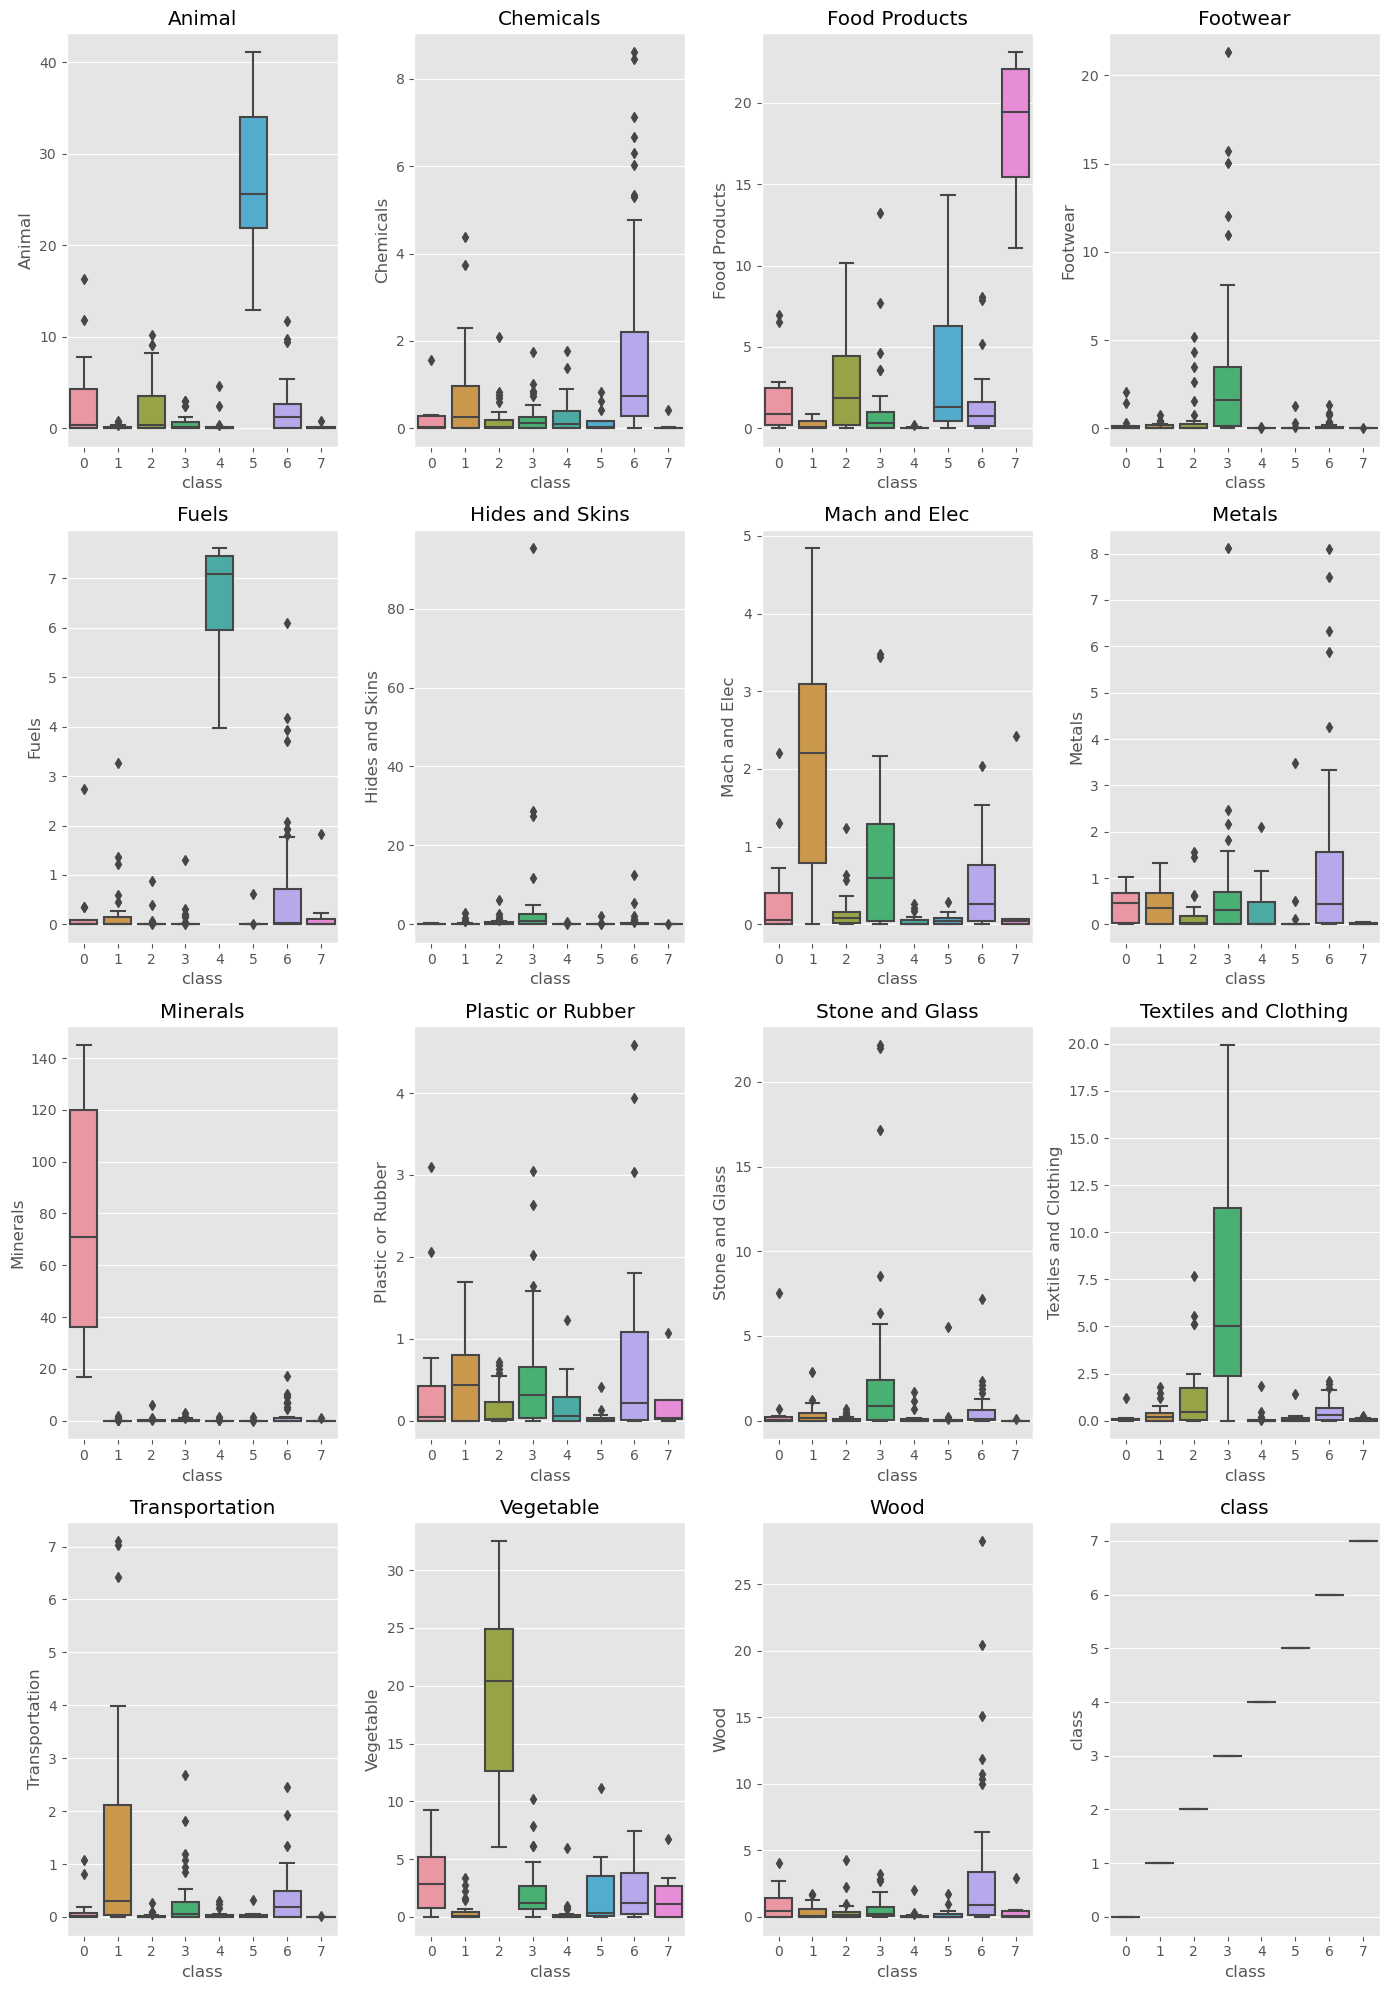

In [4]:
plt.style.use('ggplot')

num_cols = len(df_class.columns) 

# Number of rows for subplots
num_rows = num_cols // 4
if num_cols % 4:
    num_rows += 1

plt.figure(figsize=(14, 5 * num_rows))
for i, column in enumerate(df_class.columns, start=1):
    plt.subplot(num_rows, 4, i)
    sns.boxplot(x='class', y=column, data=df_class)
    plt.title(column)

plt.tight_layout()
plt.show()

In [5]:
# Group by class to have an overview of the classes features
cluster_stats = df_class.groupby('class')[df_class.columns].mean()
cluster_stats.drop("class",axis=1,inplace=True)
cluster_stats

ProductCode,Animal,Chemicals,Food Products,Footwear,Fuels,Hides and Skins,Mach and Elec,Metals,Minerals,Plastic or Rubber,Stone and Glass,Textiles and Clothing,Transportation,Vegetable,Wood
class,,,,,,,,,,,,,,,
0,3.403327,0.223603,1.855003,0.318678,0.285938,0.071374,0.400966,0.403700,77.626825,0.545518,0.736408,0.160870,0.181549,3.346667,0.980738
1,0.117701,0.703734,0.225473,0.116038,0.260394,0.293313,2.117796,0.427193,0.143126,0.497676,0.360172,0.333699,1.610326,0.486407,0.341989
2,2.245498,0.204239,2.608123,0.600337,0.044426,0.545056,0.165549,0.194390,0.278427,0.149323,0.104843,1.321487,0.022320,20.203138,0.406007
3,0.529358,0.234269,1.211988,3.443100,0.057310,5.242602,0.824632,0.673957,0.312665,0.565213,2.995844,6.842923,0.304375,2.054911,0.588821
4,0.390564,0.329692,0.029280,0.006370,6.551854,0.044445,0.049145,0.346605,0.111311,0.188321,0.197396,0.135510,0.047379,0.454711,0.146723
5,27.272222,0.156727,4.037968,0.111892,0.040512,0.169051,0.066740,0.275493,0.090456,0.045818,0.390644,0.157153,0.031239,1.983874,0.245368
6,1.953969,1.959277,1.345726,0.124485,0.759044,0.619992,0.484786,1.333720,1.955347,0.691795,0.572596,0.500070,0.375176,2.240320,3.486600
7,0.164440,0.062712,18.388683,0.004507,0.293010,0.013314,0.375289,0.013666,0.127963,0.233604,0.013484,0.063599,0.004048,1.868531,0.557804


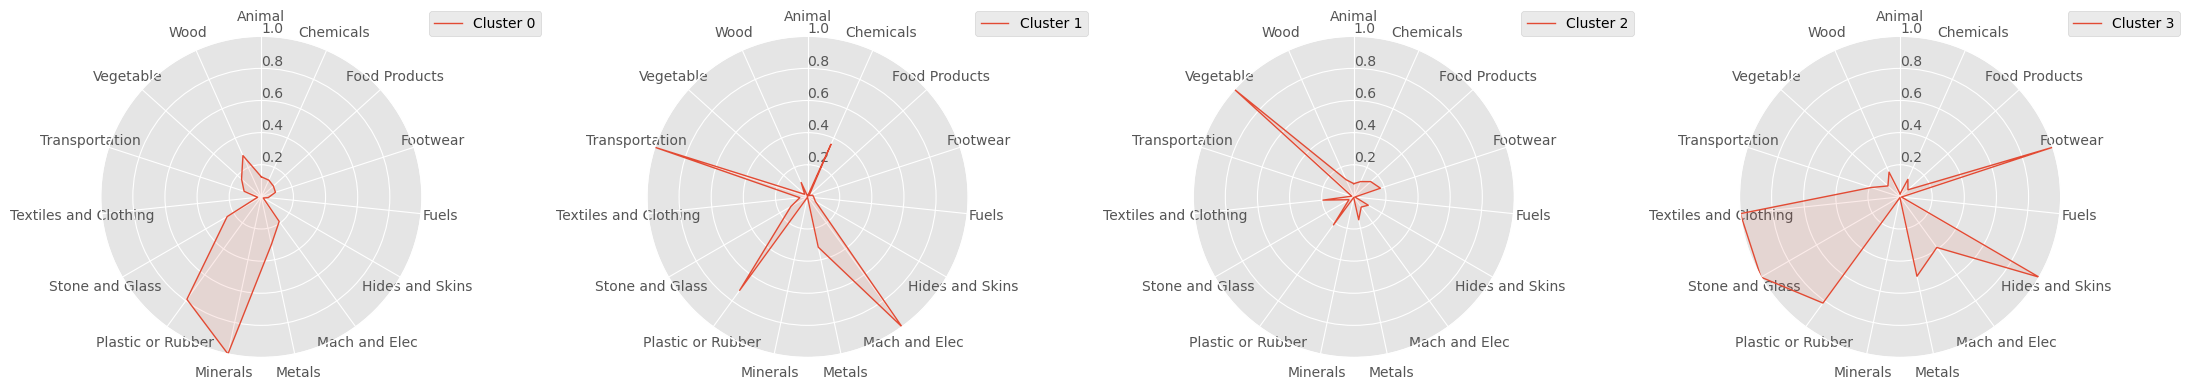

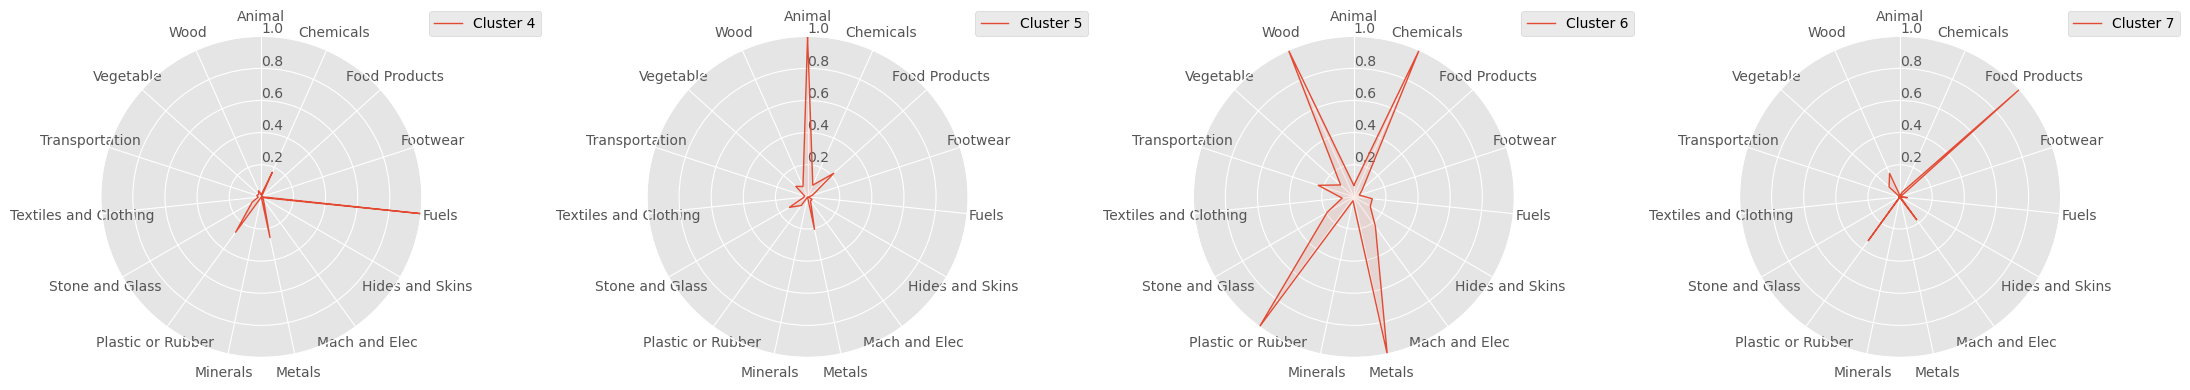

In [6]:
plt.style.use('ggplot')

# Normalize values by dividing by their maximum
cluster_stats_normalized = cluster_stats / cluster_stats.max()

# Define custom labels for each variable
variable_labels = cluster_stats_normalized.columns

# Define the number of variables
N = len(variable_labels)

# Calculate the angles for each axis
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Calculate number of rows needed
num_clusters = len(cluster_stats_normalized)
num_figures_per_row = 4
num_rows = -(-num_clusters // num_figures_per_row)  # Ceiling division

# Iterate over each cluster and create a separate figure
for i in range(num_clusters):
    if i % num_figures_per_row == 0:
        fig, axes = plt.subplots(1, num_figures_per_row,  figsize=(22, 20), subplot_kw={'polar': True})
    
    idx = i % num_figures_per_row
    ax = axes[idx]
    
    # Set axis directions
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    # Set labels for each axis (variables)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(variable_labels)
    
    # Set radial label position and y-axis limits
    ax.set_rlabel_position(0)
    ax.set_ylim(0, 1)  # Adjust y-axis limit as needed
    
    # Plot data for the current cluster
    values = cluster_stats_normalized.iloc[i].values.tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=f"Cluster {int(i)}")
    ax.fill(angles, values, alpha=0.1)
    
    # Add legend
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1.1))
    
    if (i + 1) % num_figures_per_row == 0 or i == num_clusters - 1:
        plt.tight_layout()
        plt.show()

Let's map the clusters :

C:\Users\fitah\AppData\Local\Temp\ipykernel_3372\1856214383.py:15: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


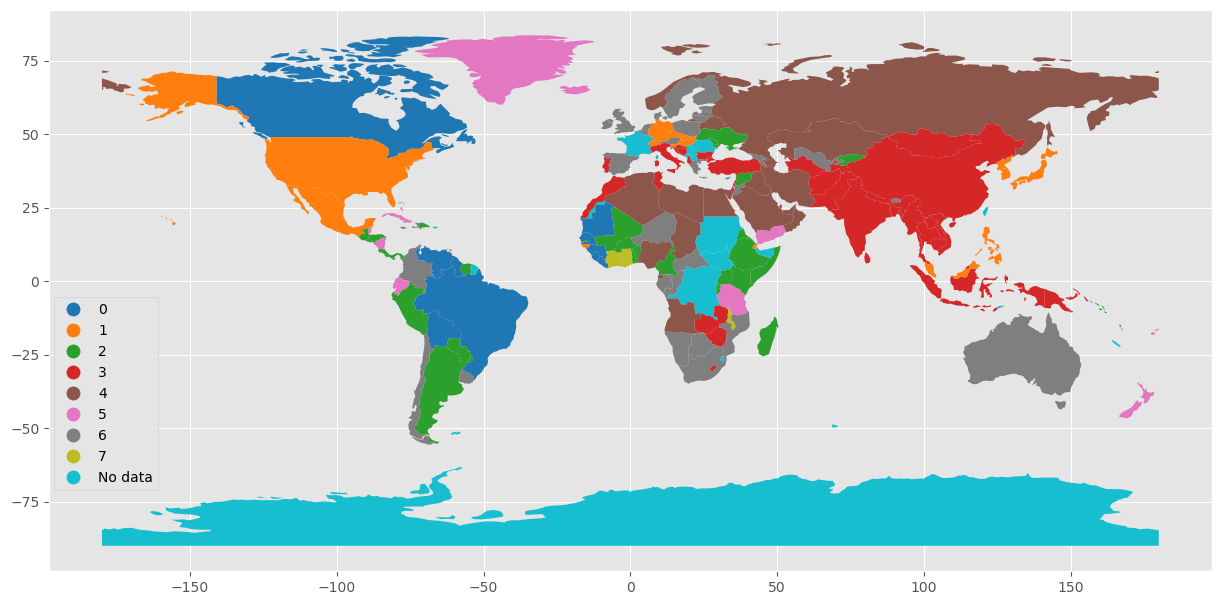

In [7]:
plt.style.use('ggplot')

# Get countries ISO code to allow merge with the geospatial countries data
countries_code = wits.get_countries().reset_index()[["iso3Code","name"]]

# Prepare initial data to merge with the geospatial countries data
df_class['class'] = df_class['class'].astype('category')
df_class.reset_index(inplace=True)
df_class.rename(columns={"index":"name"},inplace=True)

# Add to our dataframe the ISO code by country
full_df = pd.merge(df_class, countries_code, on="name")

# Load geospatial data for country borders
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge geospatial data with our dataFrame
world = world.merge(full_df, how='left', left_on='iso_a3', right_on='iso3Code')
world['class'] = world['class'].cat.add_categories("No data")
world['class'] = world['class'].fillna("No data")

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(column='class', ax=ax, legend=True)

# Get the legend and change its orientation
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.1, 0.5))

plt.show()